In [7]:
import numpy as np
import pandas as pd
from core.helper_functions import plot_mean_std_development

In [8]:
def shuffle(v):
    ids = np.arange(len(v))
    np.random.shuffle(ids)
    return v[ids]

def final_value(values:np.ndarray):
    return values[:, -1]

def improvement(values):
    return values[:, -1] - values[:, 0]

def auc(values):
    v = np.sum(values, axis=1) / values.shape[1]
    return np.squeeze(v)

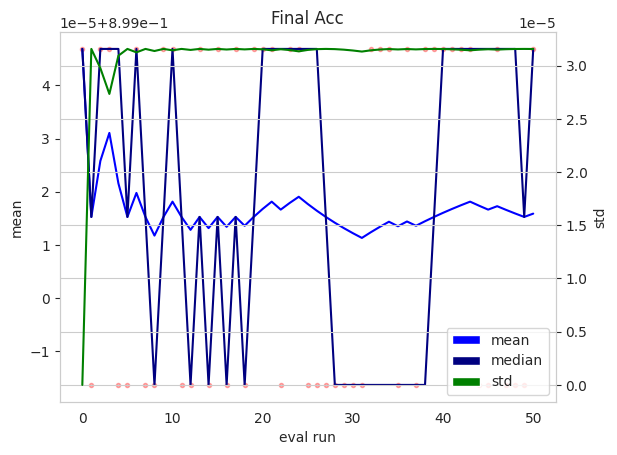

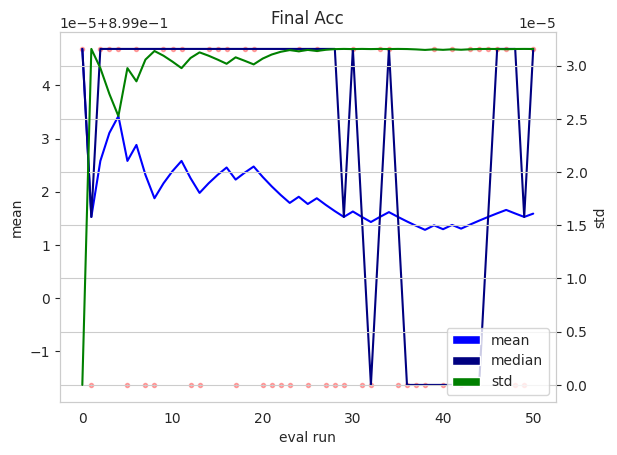

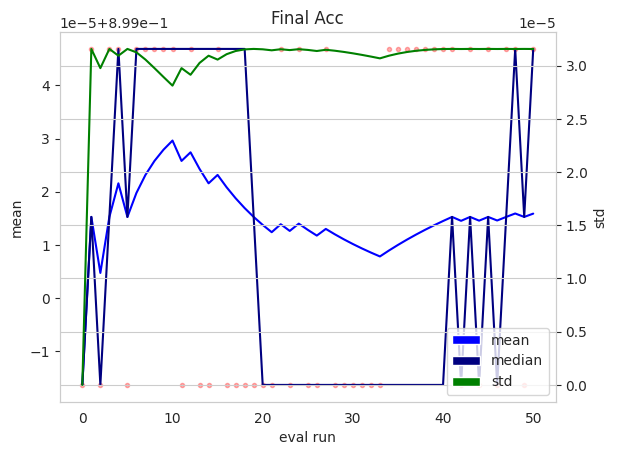

In [9]:
file = "runs/DNA/Oracle/accuracies.csv"
accuracies = pd.read_csv(file, header=0, index_col=0)
values = accuracies.values.T
v = shuffle(values)
plot_mean_std_development(auc(v), "Final Acc")
v = shuffle(values)
plot_mean_std_development(auc(v), "Final Acc")
v = shuffle(values)
plot_mean_std_development(auc(v), "Final Acc")